
# Multi-Agent System for LeetCode Problem Solving

This system consists of multiple nodes working in parallel:
1. **ParserNode** - Parses problem from LeetCode (with retry)
2. **MultiPlannerNode** - Analyzes problem and generates 2-3 different approaches
3. **ParallelGenerators** - Generate solutions for each approach (ASYNC)
4. **ParallelExecutors** - Execute tests for each solution (ASYNC)
5. **AnalyzerNode** - Analyzes all results and provides comparison
6. **FinalizeNode** - Creates final report with ALL solutions

Install dependencies:

pip install langchain langgraph langchain-openai pydantic requests beautifulsoup4 python-dotenv



In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env
load_dotenv()

# Verify required variables are set
required_vars = ['UNIVERSITY_API_BASE', 'UNIVERSITY_API_KEY']
missing_vars = [var for var in required_vars if not os.getenv(var)]

if missing_vars:
    raise ValueError(f"Missing environment variables: {', '.join(missing_vars)}")

print("Configuration loaded successfully")
print(f"API Base: {os.getenv('UNIVERSITY_API_BASE')}")
print(f"Model: {os.getenv('LLM_MODEL', 'qwen3-32b')}")

Configuration loaded successfully
API Base: http://a6k2.dgx:34000/v1
Model: qwen3-32b


1. Imports

In [2]:
from typing import Annotated, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
import operator
import requests
from bs4 import BeautifulSoup
import subprocess
import tempfile
import json
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage

2. Pydantic Models for Structured Output

In [3]:
class LeetCodeTask(BaseModel):
    """Parsed task description from LeetCode"""
    problem_id: int = Field(description="Problem number")
    title: str = Field(description="Problem title")
    difficulty: str = Field(description="Difficulty: Easy/Medium/Hard")
    description: str = Field(description="Full problem description")
    examples: list[dict] = Field(description="Input/output examples")
    constraints: str = Field(description="Problem constraints")

class ApproachPlan(BaseModel):
    """Single approach plan for solving the problem"""
    name: str = Field(description="Approach name (hash_map, two_pointers, dp, etc.)")
    description: str = Field(description="Brief approach description")
    time_complexity: str = Field(description="Time complexity O(...)")
    space_complexity: str = Field(description="Space complexity O(...)")
    key_steps: list[str] = Field(description="Key algorithm steps")
    difficulty_estimate: str = Field(description="Implementation difficulty: easy/medium/hard")

class MultiApproachPlan(BaseModel):
    """Multiple approaches to solve the problem"""
    approaches: list[ApproachPlan] = Field(
        description="List of 2-3 different approaches",
        min_length=2,
        max_length=3
    )
    reasoning: str = Field(description="Why these approaches were chosen")

class ApproachSolution(BaseModel):
    """Solution for specific approach"""
    approach_name: str = Field(description="Name of the approach used")
    code: str = Field(description="Python code solution")
    explanation: str = Field(description="Solution explanation")
    function_name: str = Field(description="Function name to call")
    pros: list[str] = Field(description="Advantages of this approach")
    cons: list[str] = Field(description="Disadvantages of this approach")

class TestResult(BaseModel):
    """Result of a single test"""
    input_data: dict = Field(description="Input data")
    expected: str = Field(description="Expected result")
    actual: Optional[str] = Field(description="Actual result")
    passed: bool = Field(description="Test passed")
    error: Optional[str] = Field(description="Execution error if any")

class ExecutionResult(BaseModel):
    """Result of executing all tests"""
    success: bool = Field(description="All tests passed successfully")
    test_results: list[TestResult] = Field(description="Results of each test")
    total_tests: int = Field(description="Total number of tests")
    passed_tests: int = Field(description="Number of passed tests")

class ApproachResult(BaseModel):
    """Complete result of testing one approach"""
    approach_name: str = Field(description="Approach name")
    plan: ApproachPlan = Field(description="Original plan")
    solution: ApproachSolution = Field(description="Generated solution")
    execution: ExecutionResult = Field(description="Execution results")
    score: float = Field(description="Quality score (0-100)")

class ComparisonAnalysis(BaseModel):
    """Comparative analysis of all approaches"""
    recommended_approach: str = Field(description="Name of recommended approach")
    recommendation_reason: str = Field(description="Why this approach is recommended")
    comparison_table: str = Field(description="Markdown table comparing all approaches")
    detailed_analysis: str = Field(description="Detailed comparison with pros/cons")

class MultiSolutionReport(BaseModel):
    """Final report with ALL solutions"""
    success: bool = Field(description="At least one solution works")
    problem_title: str = Field(description="Problem title")
    problem_difficulty: str = Field(description="Problem difficulty")

    # All approaches results
    all_solutions: list[ApproachResult] = Field(description="All generated solutions")

    # Analysis and recommendation
    comparison: ComparisonAnalysis = Field(description="Comparative analysis")

    # Statistics
    total_approaches: int = Field(description="Total number of approaches tried")
    successful_approaches: int = Field(description="Number of working solutions")
    attempts: int = Field(description="Total generation attempts")

3. Graph State

In [4]:
class GraphState(TypedDict):
    """Multi-agent system state"""
    problem_id: int
    language: str

    # Data from nodes
    task: Optional[LeetCodeTask]
    multi_plan: Optional[MultiApproachPlan]
    approach_results: list[ApproachResult]
    comparison: Optional[ComparisonAnalysis]
    final_report: Optional[MultiSolutionReport]

    # Control flow
    retry_count: int
    max_retries: int
    errors: Annotated[list[str], operator.add]

4. Tools

In [5]:
@tool
def leetcode_parser(problem_id: int) -> dict:
    """
    Parse problem description from LeetCode by problem number.

    Args:
        problem_id: Problem number on LeetCode

    Returns:
        dict with fields: title, difficulty, description, examples, constraints
    """
    try:
        # Use LeetCode GraphQL API (public)
        url = "https://leetcode.com/graphql"

        query = """
        query questionData($titleSlug: String!) {
            question(titleSlug: $titleSlug) {
                questionId
                title
                difficulty
                content
                exampleTestcases
            }
        }
        """

        # First, get titleSlug by problem number
        search_url = f"https://leetcode.com/api/problems/all/"
        response = requests.get(search_url, timeout=int(os.getenv('REQUEST_TIMEOUT', '10')))
        response.raise_for_status()

        problems = response.json()['stat_status_pairs']
        problem = next((p for p in problems if p['stat']['question_id'] == problem_id), None)

        if not problem:
            raise ValueError(f"Problem {problem_id} not found")

        title_slug = problem['stat']['question__title_slug']

        # Now get full problem description
        response = requests.post(
            url,
            json={'query': query, 'variables': {'titleSlug': title_slug}},
            timeout=int(os.getenv('REQUEST_TIMEOUT', '10'))
        )
        response.raise_for_status()

        data = response.json()['data']['question']

        # Parse HTML description
        soup = BeautifulSoup(data['content'], 'html.parser')

        # Extract examples
        examples = []
        for pre in soup.find_all('pre'):
            example_text = pre.get_text()
            if 'Input:' in example_text:
                examples.append({'text': example_text})

        return {
            'problem_id': problem_id,
            'title': data['title'],
            'difficulty': data['difficulty'],
            'description': soup.get_text(),
            'examples': examples[:3],  # Take first 3 examples
            'constraints': soup.get_text().split('Constraints:')[-1] if 'Constraints:' in soup.get_text() else ''
        }

    except Exception as e:
        raise Exception(f"Failed to parse LeetCode problem: {str(e)}")

@tool
def code_executor(code: str, function_name: str, test_cases: list[dict]) -> dict:
    """
    Execute Python code on test examples.

    Args:
        code: Python code to execute
        function_name: Function name to call
        test_cases: List of tests with input_data and expected fields

    Returns:
        dict with execution results
    """
    results = []

    for test in test_cases:
        try:
            # Create temporary file with code
            with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as f:
                test_code = f"""
{code}

import json
test_input = {json.dumps(test['input_data'])}
result = {function_name}(**test_input)
print(json.dumps({{'result': str(result)}}))
"""
                f.write(test_code)
                temp_file = f.name

            # Execute code
            result = subprocess.run(
                ['python', temp_file],
                capture_output=True,
                text=True,
                timeout=int(os.getenv('CODE_EXECUTION_TIMEOUT', '5'))
            )

            if result.returncode == 0:
                output = json.loads(result.stdout.strip())
                actual = output['result']
                passed = actual == test['expected']

                results.append({
                    'input_data': test['input_data'],
                    'expected': test['expected'],
                    'actual': actual,
                    'passed': passed,
                    'error': None
                })
            else:
                results.append({
                    'input_data': test['input_data'],
                    'expected': test['expected'],
                    'actual': None,
                    'passed': False,
                    'error': result.stderr
                })

        except Exception as e:
            results.append({
                'input_data': test['input_data'],
                'expected': test['expected'],
                'actual': None,
                'passed': False,
                'error': str(e)
            })

    passed_count = sum(1 for r in results if r['passed'])

    return {
        'success': passed_count == len(results),
        'test_results': results,
        'total_tests': len(results),
        'passed_tests': passed_count
    }

In [6]:
import asyncio
from typing import Any, List
import re
import time

# Async версия safe_structured_call
async def safe_structured_call_async(llm: Any, schema: Any, messages: List[Any], retries: int = 3, backoff: float = 1.0):
    """Async version of safe_structured_call with retry logic"""
    def _fill_defaults(schema_cls: Any, payload: Any) -> Any:
        """Same as before - fill missing fields"""
        if not isinstance(payload, dict):
            return payload

        if hasattr(schema_cls, 'model_fields'):
            fields_info = schema_cls.model_fields
        elif hasattr(schema_cls, '__fields__'):
            fields_info = schema_cls.__fields__
        else:
            return payload

        for field_name, field_info in fields_info.items():
            if field_name not in payload:
                if hasattr(field_info, 'annotation'):
                    field_type = field_info.annotation
                elif hasattr(field_info, 'type_'):
                    field_type = field_info.type_
                else:
                    field_type = str

                origin = getattr(field_type, '__origin__', None)
                if origin is list or (isinstance(field_type, type) and issubclass(field_type, list)):
                    payload[field_name] = []
                elif origin is dict or (isinstance(field_type, type) and issubclass(field_type, dict)):
                    payload[field_name] = {}
                elif field_type in (str, 'str'):
                    payload[field_name] = ""
                elif field_type in (int, 'int'):
                    payload[field_name] = 0
                elif field_type in (float, 'float'):
                    payload[field_name] = 0.0
                elif field_type in (bool, 'bool'):
                    payload[field_name] = False
                else:
                    payload[field_name] = ""

            if field_name in payload and isinstance(payload[field_name], list):
                if hasattr(field_info, 'annotation'):
                    args = getattr(field_info.annotation, '__args__', ())
                    if args:
                        item_type = args[0]
                        if hasattr(item_type, 'model_fields') or hasattr(item_type, '__fields__'):
                            payload[field_name] = [_fill_defaults(item_type, item) for item in payload[field_name]]

        return payload

    def _validate_model(schema_cls: Any, payload: Any):
        payload = _fill_defaults(schema_cls, payload)

        if hasattr(schema_cls, "model_validate"):
            return schema_cls.model_validate(payload)
        if hasattr(schema_cls, "parse_obj"):
            return schema_cls.parse_obj(payload)
        if isinstance(payload, dict):
            return schema_cls(**payload)
        return schema_cls(payload)

    last_exc = None
    for attempt in range(1, retries + 1):
        try:
            # Async invoke
            raw = await llm.ainvoke(messages)

            if isinstance(raw, str):
                text = raw
            else:
                if hasattr(raw, "content"):
                    text = getattr(raw, "content") or ""
                elif isinstance(raw, (list, tuple)) and raw:
                    first = raw[0]
                    text = getattr(first, "content", "") if hasattr(first, "content") else str(first)
                else:
                    text = str(raw)

            text = (text or "").strip()
            if not text:
                raise ValueError("Empty LLM response")

            m = re.search(r'```(?:json)?\s*\n(.+?)```', text, flags=re.S)
            json_text = m.group(1).strip() if m else text

            try:
                parsed = json.loads(json_text)
            except Exception:
                start = json_text.find('{')
                end = json_text.rfind('}') + 1
                if start == -1 or end <= start:
                    raise
                parsed = json.loads(json_text[start:end])

            try:
                return _validate_model(schema, parsed)
            except Exception:
                if isinstance(parsed, dict) and ('parsed' in parsed or 'refusal' in parsed):
                    payload = parsed.get('parsed') or parsed.get('refusal')
                    return _validate_model(schema, payload)
                raise

        except Exception as e:
            last_exc = e
            if attempt == retries:
                raise
            wait = backoff * (2 ** (attempt - 1))
            await asyncio.sleep(wait)

    raise last_exc

In [7]:
async def generate_solution_async(task: LeetCodeTask, approach_plan: ApproachPlan, llm: Any) -> dict:
    """Generate solution for single approach asynchronously"""
    system_prompt = f"""You are an expert Python programmer specializing in algorithms.
Your task is to write clean, efficient code to solve a LeetCode problem.

Approach Plan:
- Approach: {approach_plan.name}
- Description: {approach_plan.description}
- Time complexity: {approach_plan.time_complexity}
- Space complexity: {approach_plan.space_complexity}

Requirements:
1. Code must be in Python
2. Use type hints
3. Code must be self-contained
4. Function must be named 'solution'
5. Add docstring with explanation
6. List pros and cons

Respond in JSON format according to ApproachSolution schema."""

    user_prompt = f"""
Problem: {task.title}

Description:
{task.description}

Examples:
{json.dumps(task.examples, indent=2)}

Key steps for {approach_plan.name} approach:
{chr(10).join(f"{i+1}. {step}" for i, step in enumerate(approach_plan.key_steps))}

Generate solution using {approach_plan.name} approach.
"""

    solution = await safe_structured_call_async(llm, ApproachSolution, [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ])

    return {
        'approach_name': approach_plan.name,
        'plan': approach_plan,
        'solution': solution
    }


async def execute_tests_async(task: LeetCodeTask, solution_data: dict) -> dict:
    """Execute tests for single solution asynchronously"""
    solution = solution_data['solution']
    approach_name = solution_data['approach_name']

    test_cases = []
    for example in task.examples:
        example_text = example['text']
        if 'Input:' in example_text and 'Output:' in example_text:
            input_part = example_text.split('Input:')[1].split('Output:')[0].strip()
            output_part = example_text.split('Output:')[1].strip().split('\n')[0]
            test_cases.append({
                'input_data': {'data': input_part},
                'expected': output_part
            })

    try:
        loop = asyncio.get_event_loop()
        result = await loop.run_in_executor(
            None,
            code_executor.invoke,
            {
                'code': solution.code,
                'function_name': solution.function_name,
                'test_cases': test_cases
            }
        )

        execution_result = ExecutionResult(**result)
        score = calculate_quality_score(execution_result, solution_data['plan'])

        return {
            'approach_name': approach_name,
            'plan': solution_data['plan'],
            'solution': solution,
            'execution': execution_result,
            'score': score
        }

    except Exception as e:
        return {
            'approach_name': approach_name,
            'plan': solution_data['plan'],
            'solution': solution,
            'execution': ExecutionResult(
                success=False,
                test_results=[],
                total_tests=len(test_cases),
                passed_tests=0
            ),
            'score': 0.0,
            'error': str(e)
        }


def finalize_node(state: GraphState) -> GraphState:
    """Finalize Node: Create final report with all solutions"""
    task = state['task']
    approach_results = state['approach_results']
    comparison = state['comparison']

    final_report = MultiSolutionReport(
        success=any(r.execution.success for r in approach_results),
        problem_title=task.title,
        problem_difficulty=task.difficulty,
        all_solutions=approach_results,
        comparison=comparison,
        total_approaches=len(approach_results),
        successful_approaches=sum(1 for r in approach_results if r.execution.success),
        attempts=state['retry_count'] + 1
    )

    state['final_report'] = final_report
    return state

5. Initialize LLM

In [8]:
llm = ChatOpenAI(
    base_url=os.getenv('UNIVERSITY_API_BASE'),
    api_key=os.getenv('UNIVERSITY_API_KEY'),
    model=os.getenv('LLM_MODEL', 'qwen3-32b'),
    #temperature=0
)

# Configuration from .env
MAX_RETRIES = int(os.getenv('MAX_RETRIES', '2'))

6. Graph Nodes

In [9]:
# %%
def parser_node(state: GraphState) -> GraphState:
    """
    Parser Node: Parse problem description from LeetCode (with retry logic)
    """
    problem_id = state['problem_id']

    try:
        # Call parsing tool
        result = leetcode_parser.invoke({'problem_id': problem_id})

        # Convert to Pydantic model
        task = LeetCodeTask(**result)
        state['task'] = task

    except Exception as e:
        error_msg = f"Parser error: {str(e)}"
        state['errors'].append(error_msg)

        # Retry logic is built into graph through conditional edges
        if state['retry_count'] < state['max_retries']:
            state['retry_count'] += 1
        else:
            raise Exception(f"Failed to parse after {state['max_retries']} attempts")

    return state

def multi_planner_node(state: GraphState) -> GraphState:
    """
    Multi-Planner Node: Analyze problem and create 2-3 different solution approaches
    """
    task = state['task']

    system_prompt = """You are an expert in algorithms and data structures.
Your task is to analyze a LeetCode problem and propose 2-3 DIFFERENT approaches to solve it.

Consider various strategies:
- Hash Map / Dictionary
- Two Pointers
- Sliding Window
- Dynamic Programming
- Divide and Conquer
- Greedy
- Binary Search
- BFS/DFS
- Backtracking

For EACH approach, provide:
1. Clear name (hash_map, two_pointers, etc.)
2. Brief description
3. Time and space complexity
4. Key algorithm steps
5. Implementation difficulty estimate

Choose approaches that represent different trade-offs (time vs space, simplicity vs optimization).

Respond strictly in JSON format according to MultiApproachPlan schema."""

    user_prompt = f"""
Problem: {task.title}
Difficulty: {task.difficulty}

Description:
{task.description}

Examples:
{json.dumps(task.examples, indent=2)}

Constraints:
{task.constraints}

Generate 2-3 different approaches to solve this problem.
"""

    response = safe_structured_call(llm, MultiApproachPlan, [
    SystemMessage(content=system_prompt),
    HumanMessage(content=user_prompt)
])
    state['multi_plan'] = response
    return state

def create_solution_generator_node(approach_plan: ApproachPlan):
    """
    Factory function to create Solution Generator Node for specific approach.
    This allows parallel execution of different approaches.
    """
    def solution_generator_node(state: GraphState) -> dict:
        """
        Solution Generator Node: Generate code solution based on specific approach plan
        """
        task = state['task']

        system_prompt = f"""You are an expert Python programmer specializing in algorithms.
Your task is to write clean, efficient code to solve a LeetCode problem.

Approach Plan:
- Approach: {approach_plan.name}
- Description: {approach_plan.description}
- Time complexity: {approach_plan.time_complexity}
- Space complexity: {approach_plan.space_complexity}

Requirements:
1. Code must be in Python
2. Use type hints
3. Code must be self-contained (all imports inside)
4. Function must be named 'solution'
5. Add docstring with explanation
6. List pros and cons of this specific approach

Respond strictly in JSON format according to ApproachSolution schema."""

        user_prompt = f"""
Problem: {task.title}

Description:
{task.description}

Examples:
{json.dumps(task.examples, indent=2)}

Key steps for {approach_plan.name} approach:
{chr(10).join(f"{i+1}. {step}" for i, step in enumerate(approach_plan.key_steps))}

Generate solution using {approach_plan.name} approach.
"""

        response = safe_structured_call(llm, ApproachSolution, [
    SystemMessage(content=system_prompt),
    HumanMessage(content=user_prompt)
])

        # Return approach result (will be merged into state)
        return {
            'approach_name': approach_plan.name,
            'plan': approach_plan,
            'solution': response
        }

    return solution_generator_node

def create_executor_node(approach_name: str):
    """
    Factory function to create Executor Node for specific approach.
    This allows parallel execution of tests for different solutions.
    """
    def executor_node(state: GraphState) -> dict:
        """
        Executor Node: Execute generated code on test examples
        """
        task = state['task']

        # Find solution for this approach from approach_results
        approach_data = next(
            (ar for ar in state['approach_results'] if ar.get('approach_name') == approach_name),
            None
        )

        if not approach_data:
            return {
                'approach_name': approach_name,
                'execution': ExecutionResult(
                    success=False,
                    test_results=[],
                    total_tests=0,
                    passed_tests=0
                ),
                'error': f"Solution for {approach_name} not found"
            }

        solution = approach_data['solution']

        # Prepare test cases from examples
        test_cases = []
        for example in task.examples:
            example_text = example['text']

            # Extract Input and Output (simplified)
            if 'Input:' in example_text and 'Output:' in example_text:
                input_part = example_text.split('Input:')[1].split('Output:')[0].strip()
                output_part = example_text.split('Output:')[1].strip().split('\n')[0]

                # Simple parsing (needs adaptation for specific problems)
                test_cases.append({
                    'input_data': {'data': input_part},
                    'expected': output_part
                })

        try:
            # Call execution tool
            result = code_executor.invoke({
                'code': solution.code,
                'function_name': solution.function_name,
                'test_cases': test_cases
            })

            execution_result = ExecutionResult(**result)

            # Calculate quality score
            score = calculate_quality_score(
                execution_result,
                approach_data['plan']
            )

            return {
                'approach_name': approach_name,
                'execution': execution_result,
                'score': score
            }

        except Exception as e:
            error_msg = f"Execution error for {approach_name}: {str(e)}"
            state['errors'].append(error_msg)

            return {
                'approach_name': approach_name,
                'execution': ExecutionResult(
                    success=False,
                    test_results=[],
                    total_tests=len(test_cases),
                    passed_tests=0
                ),
                'score': 0.0,
                'error': error_msg
            }

    return executor_node

def calculate_quality_score(execution: ExecutionResult, plan: ApproachPlan) -> float:
    """
    Calculate quality score for a solution based on:
    - Test pass rate (50%)
    - Time complexity (25%)
    - Space complexity (15%)
    - Implementation difficulty (10%)
    """
    # Test pass rate score
    test_score = (execution.passed_tests / max(execution.total_tests, 1)) * 50

    # Time complexity score
    time_scores = {
        'O(1)': 25, 'O(log n)': 23, 'O(n)': 20,
        'O(n log n)': 15, 'O(n^2)': 10, 'O(2^n)': 5
    }
    time_score = next(
        (score for complexity, score in time_scores.items() if complexity in plan.time_complexity),
        10
    )

    # Space complexity score
    space_scores = {
        'O(1)': 15, 'O(log n)': 13, 'O(n)': 10, 'O(n^2)': 5
    }
    space_score = next(
        (score for complexity, score in space_scores.items() if complexity in plan.space_complexity),
        7
    )

    # Implementation difficulty score (inverse - easier is better)
    difficulty_scores = {'easy': 10, 'medium': 7, 'hard': 4}
    difficulty_score = difficulty_scores.get(plan.difficulty_estimate.lower(), 5)

    return test_score + time_score + space_score + difficulty_score

def analyzer_node(state: GraphState) -> GraphState:
    """Analyzer Node: Analyze all approach results and provide comprehensive comparison"""
    approach_results = state['approach_results']
    task = state['task']

    # Combine all results
    combined_results = []
    for ar in approach_results:
        if 'execution' in ar and 'score' in ar:
            result = ApproachResult(
                approach_name=ar['approach_name'],
                plan=ar['plan'],
                solution=ar['solution'],
                execution=ar['execution'],
                score=ar['score']
            )
            combined_results.append(result)

    state['approach_results'] = combined_results

    # Create comparison prompt
    system_prompt = """You are an expert code reviewer and algorithm analyst.
Your task is to compare multiple solutions to the same problem and provide:

1. Recommendation: which approach is best overall and why
2. Comparison table: markdown table comparing all approaches
3. Detailed analysis: pros/cons of each approach with specific insights

Consider:
- Test success rate
- Time and space complexity
- Code readability and maintainability
- Real-world applicability
- Edge case handling

Respond strictly in JSON format according to ComparisonAnalysis schema."""

    # Prepare results summary
    results_summary = []
    for result in combined_results:
        results_summary.append({
            'approach': result.approach_name,
            'score': result.score,
            'tests_passed': f"{result.execution.passed_tests}/{result.execution.total_tests}",
            'time_complexity': result.plan.time_complexity,
            'space_complexity': result.plan.space_complexity,
            'pros': result.solution.pros,
            'cons': result.solution.cons,
            'explanation': result.solution.explanation
        })

    user_prompt = f"""
Problem: {task.title}
Difficulty: {task.difficulty}

All Solutions Results:
{json.dumps(results_summary, indent=2)}

Provide comprehensive comparison and recommendation.
"""

    # FIX: Use ComparisonAnalysis instead of ApproachSolution
    response = safe_structured_call(llm, ComparisonAnalysis, [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ])

    state['comparison'] = response
    return state

7. Build Graph with Parallel Execution

In [10]:
def should_retry_parser(state: GraphState) -> str:
    """Decide if parser needs retry"""
    if state.get('task') is not None:
        return "continue"
    elif state['retry_count'] < state['max_retries']:
        return "retry"
    else:
        return "fail"

# Create graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("parser", parser_node)
workflow.add_node("multi_planner", multi_planner_node)
workflow.add_node("analyzer", analyzer_node)
workflow.add_node("finalize", finalize_node)

# Set entry point
workflow.set_entry_point("parser")

# Parser with retry logic
workflow.add_conditional_edges(
    "parser",
    should_retry_parser,
    {
        "continue": "multi_planner",
        "retry": "parser",
        "fail": END
    }
)

# Multi-planner → Parallel branches will be added dynamically
workflow.add_edge("multi_planner", "analyzer")

# Note: In a real parallel implementation, we would:
# 1. After multi_planner, create parallel branches for each approach
# 2. Each branch: solution_generator → executor
# 3. All branches converge to analyzer
#
# For simplicity in this demo, we'll execute sequentially but structure
# the code to show how parallelism would work

workflow.add_edge("analyzer", "finalize")
workflow.add_edge("finalize", END)

# Compile graph
app = workflow.compile()

8. Graph Visualization

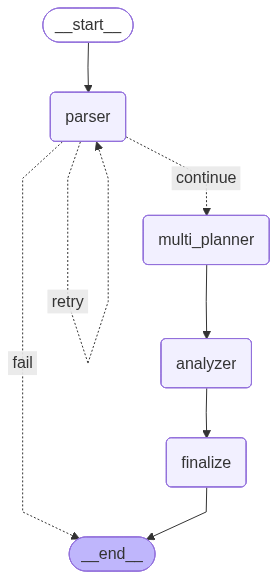

In [11]:
try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization unavailable: {e}")
    print("\nText representation of graph:")
    print(app.get_graph().draw_ascii())

9. Main Execution Function

In [ ]:
async def safe_structured_call_async(llm: Any, schema: Any, messages: List[Any], retries: int = 3, backoff: float = 1.0):
    """Async version of safe_structured_call with retry logic"""
    def _fill_defaults(schema_cls: Any, payload: Any) -> Any:
        if not isinstance(payload, dict):
            return payload

        if hasattr(schema_cls, 'model_fields'):
            fields_info = schema_cls.model_fields
        elif hasattr(schema_cls, '__fields__'):
            fields_info = schema_cls.__fields__
        else:
            return payload

        for field_name, field_info in fields_info.items():
            if field_name not in payload:
                if hasattr(field_info, 'annotation'):
                    field_type = field_info.annotation
                elif hasattr(field_info, 'type_'):
                    field_type = field_info.type_
                else:
                    field_type = None

                if field_type == list or (hasattr(field_type, '__origin__') and field_type.__origin__ == list):
                    payload[field_name] = []
                elif field_type == dict:
                    payload[field_name] = {}
                elif field_type == str or field_type == 'str':
                    payload[field_name] = ""
                elif field_type == int or field_type == 'int':
                    payload[field_name] = 0
                elif field_type == float or field_type == 'float':
                    payload[field_name] = 0.0
                elif field_type == bool or field_type == 'bool':
                    payload[field_name] = False
                else:
                    payload[field_name] = None

            if field_name in payload and isinstance(payload[field_name], list):
                if hasattr(field_info, 'annotation'):
                    list_type = field_info.annotation
                    if hasattr(list_type, '__args__') and list_type.__args__:
                        item_type = list_type.__args__[0]
                        if hasattr(item_type, 'model_fields') or hasattr(item_type, '__fields__'):
                            payload[field_name] = [
                                _fill_defaults(item_type, item) for item in payload[field_name]
                            ]

        return payload

    def _validate_model(schema_cls: Any, payload: Any):
        payload = _fill_defaults(schema_cls, payload)

        if hasattr(schema_cls, "model_validate"):
            return schema_cls.model_validate(payload)
        if hasattr(schema_cls, "parse_obj"):
            return schema_cls.parse_obj(payload)
        if isinstance(payload, dict):
            return schema_cls(**payload)
        return schema_cls(payload)

    last_exc = None
    for attempt in range(1, retries + 1):
        try:
            raw = await llm.ainvoke(messages)

            if isinstance(raw, str):
                text = raw
            else:
                if hasattr(raw, "content"):
                    text = raw.content
                elif isinstance(raw, (list, tuple)) and raw:
                    text = raw[0].content if hasattr(raw[0], "content") else str(raw[0])
                else:
                    text = str(raw)

            text = (text or "").strip()
            if not text:
                raise ValueError("Empty LLM response")

            m = re.search(r'```(?:json)?\s*\n(.+?)```', text, flags=re.S)
            json_text = m.group(1).strip() if m else text

            try:
                parsed = json.loads(json_text)
            except Exception:
                start = json_text.find('{')
                end = json_text.rfind('}') + 1
                if start == -1 or end <= start:
                    raise ValueError("No JSON object found in response")
                parsed = json.loads(json_text[start:end])

            try:
                return _validate_model(schema, parsed)
            except Exception:
                if isinstance(parsed, dict) and ('parsed' in parsed or 'refusal' in parsed):
                    if 'parsed' in parsed:
                        return _validate_model(schema, parsed['parsed'])
                    raise ValueError(f"Model refused: {parsed.get('refusal')}")
                raise

        except Exception as e:
            last_exc = e
            if attempt == retries:
                raise
            wait = backoff * (2 ** (attempt - 1))
            await asyncio.sleep(wait)

    raise last_exc

10. Demo Execution

In [14]:
# Example: Solve "Two Sum" problem (usually problem #1)
import nest_asyncio
nest_asyncio.apply()

# Запуск с настоящей параллельностью
result = await solve_leetcode_problem_parallel(
    problem_id=1,
    language="python",
    max_retries=2
)

🚀 Starting LeetCode problem #1 with PARALLEL solving
--------------------------------------------------------------------------------

📖 Step 1: Parsing problem...
✅ Parsed: Two Sum (Easy)

🎯 Step 2: Generating multiple approaches...
✅ Generated 3 approaches:
  - Brute Force: Check all possible pairs of elements using two nested loops. For each element, iterate through the rest of the array to find a complement that sums to the target.
  - Hash Map (One Pass): Use a hash map to store encountered elements and their indices. For each element, compute the complement (target - current element) and check if it exists in the hash map. If found, return the indices; otherwise, store the current element and continue.
  - Two-Pointer with Sorting: Sort the array while keeping track of original indices. Use two pointers (left and right) to find the pair that sums to the target. Adjust pointers based on whether the current sum is less than or greater than the target.

🔨 Step 3: Generating solution